In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import root

In [3]:
#Create the matrix as defined by Uehara:
def detMuVECTa(a_s,q,kappa,tol = 1e-3,mu = 0):
    #Approximate Delta(mu) as defined by Hasegawa & Uehara
    #
    # PARAMETERS
    # a - a value for trapping
    # q - q value for trapping
    # kappa - friction term, see Hasegawa & Uehara for further details
    # tol - relative tolerance at which to stop calculating
    

    res = []
    for a in a_s:
        currentS = 1
        nextS = 2
        currentMatrix = makeMatrix(a,q,kappa,currentS)
        nextMatrix = makeMatrix(a,q,kappa,nextS)
        rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)
        while np.abs(rel_diff) > tol:
            nextS +=1
            currentS +=1
            currentMatrix = makeMatrix(a,q,kappa,currentS,mu)
            nextMatrix = makeMatrix(a,q,kappa,nextS,mu)
            rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)
            res.append(np.linalg.det(currentMatrix))
    return np.array(res)


def chi(a,q,kappa,s,mu = 0):
    #
    # PARAMETERS
    # a - a value for the trap
    # q - q value for the trap
    # kappa - friction term, see Hasegawa & Uehara for further details
    # s - integer number for which chi is defined
    # mu - complex number
    #
    #
    # RETURN
    # chi - chi_s(a,q,kappa)  as defined by Hasegawa & Uehara
    return q/((2*s-1j*mu)**2 -a + kappa**2)
    #return s


def makeMatrix(a,q,kappa,S_max, mu= 0):
    #
    # PARAMETERS
    # a - a value for trapping
    # q - q value for trapping
    # kappa - friction term, see Hasegawa & Uehara for further details
    # S_max - max value for which to compute chi_s matrix
    # 
    # RETURN
    # tridiagonal matrix as defined by Hasegawa & Uehara of dimension 2*S_max + 1
    matrix = np.identity(2*S_max+1,dtype = np.complex128)
    length = matrix.shape[0]
    matrix[0,1] = chi(a,q,kappa,-S_max)
    matrix[length-1,length-2] = chi(a,q,kappa,S_max)
    for j in range(1,length-1):
        s = j-S_max
        matrix[j,j+1] = chi(a,q,kappa,s,mu)
        matrix[j,j-1] = chi(a,q,kappa,-s,mu)
    return matrix

def detMu(a,q,kappa,tol = 1e-3,mu = 0):
    #Approximate Delta(mu) as defined by Hasegawa & Uehara
    #
    # PARAMETERS
    # a - a value for trapping
    # q - q value for trapping
    # kappa - friction term, see Hasegawa & Uehara for further details
    # tol - relative tolerance at which to stop calculating
    
    
    currentS = 1
    nextS = 2
    currentMatrix = makeMatrix(a,q,kappa,currentS)
    nextMatrix = makeMatrix(a,q,kappa,nextS)
    rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)
    while np.abs(rel_diff) > tol:
        nextS +=1
        currentS +=1
        currentMatrix = makeMatrix(a,q,kappa,currentS,mu)
        nextMatrix = makeMatrix(a,q,kappa,nextS,mu)
        rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)
    return np.linalg.det(currentMatrix)#, currentS

def isStable(a,q,kappa, tol = 1e-3):
    detVal = detMu(a,q,kappa,tol)
    checkValue = detVal*(np.sin(np.pi/2 * np.sqrt(a-kappa**2,dtype = np.complex128)))**2
    if checkValue > 1: ###CASE 1
        alpha = 2/np.pi * np.arccosh(np.sqrt(checkValue,dtype = np.complex128))
        if alpha <= kappa:
            return True
        else:
            return False
    elif checkValue >= 0: ###CASE 2
        return True 
    else: ###CASE 3
        alpha = 2/np.pi * np.arcsinh(np.sqrt(-checkValue,dtype = np.complex128))
        if alpha <= kappa:
            return True
        else:
            return False


def makeStabilityDiagram(a_array,q_array,kappa,tol = 1e-3):
    # 
    # PARAMETERS
    # a - array of a values for which to determine stability over
    # q - array of q values over which to determine stability over
    # kappa- friction term, see Hasegawa & Uehara for further details
    

    top_a = []
    top_q = []
    bottom_a = []
    bottom_q = []
    for idx,q in enumerate(q_array):
        #print(rf'At index {idx} out of {len(q_array)}')
        #Bottom Line
        for a in a_array:
            if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                bottom_a.append(a)
                bottom_q.append(q)
                break
        #Top Line
        for a in np.flip(a_array):
            if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                top_a.append(a)
                top_q.append(q)
                break
    return [np.array(top_a),np.array(top_q),np.array(bottom_a),np.array(bottom_q)]
#print(detMu(0,0.5,0.002)[0])

def makeStabilityDiagramDEVELOP(a_array,q_array,kappa,N = 100,tol = 1e-3):
    # 
    # PARAMETERS
    # a - array of a values for which to determine stability over
    # q - array of q values over which to determine stability over
    # kappa- friction term, see Hasegawa & Uehara for further details
    

    top_a = []
    top_q = []
    bottom_a = []
    bottom_q = []
    for idx,q in enumerate(q_array):
        #print(rf'At index {idx} out of {len(q_array)}')
        #Bottom Line
        if not top_a:
            for a in a_array:
                if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                    bottom_a.append(a)
                    bottom_q.append(q)
                    print(a,q)
                    break
                #Top Line
            for a in np.flip(a_array):
                if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                    top_a.append(a)
                    top_q.append(q)
                    break   
        else:
            search_A_down_from = top_a[-1]+0.1
            search_A_up_from = bottom_a[-1]-0.1
            for a in np.linspace(search_A_up_from,bottom_a[-1]+0.1,N):
                if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                    bottom_a.append(a)
                    bottom_q.append(q)
                    break
            for a in np.flip(np.linspace(top_a[-1]-0.1,search_A_down_from,N)):
                if np.bitwise_and(isStable(a,q,kappa,tol),isStable(-0.5*a,-0.5*q,kappa,tol)):
                    top_a.append(a)
                    top_q.append(q)
                    break
    return [top_a,top_q,bottom_a,bottom_q]

def rootFinderStability(q,k):
    def alpha(a):
        CheckValue = detMuVECTa(a,q,k)*np.sin(np.pi/2*np.sqrt(a-k**2))**2
        if CheckValue > 1:
            return np.real(2/np.pi/(np.arccosh(np.sqrt(CheckValue)))-k)
        elif CheckValue > 0:
            return np.real(0-k)
        else:
            return np.real(2/np.pi/(np.arcsinh(np.sqrt(-CheckValue)))-k)
    return root(alpha,x0 = 0)



def upper_a(q,kappa):
    for a in np.flip(np.linspace(-0.5,0.5,500)):
        if np.bitwise_and(isStable(a,q,kappa),isStable(-0.5*a,-0.5*q,kappa)):
            break
    return a
def lower_a(q,kappa):
    for a in np.linspace(-0.5,0.5,500):
        if np.bitwise_and(isStable(a,q,kappa),isStable(-0.5*a,-0.5*q,kappa)):
            break
    return a

def upper_a_VECTORIZED(qs,kappa):
    result = []
    for q in qs:
        result.append(upper_a(q,kappa))
    return np.array(result)


In [11]:
# a_array = np.linspace(-1,1,100)
# q_array= np.linspace(0,1.5,100)

# [topA,topQ,bottomA,bottomQ] = makeStabilityDiagramDEVELOP(a_array,q_array,0.002)
# #[topA2,topQ2,bottomA2,bottomQ2] = makeStabilityDiagram(a_array,q_array,0.002)

# plt.plot(topQ,topA,color = 'k')
# plt.plot(bottomQ,bottomA,color = 'k')


# # plt.plot(topQ2,topA2,color = 'k', ls = '--')
# # plt.plot(bottomQ2,bottomA2,color = 'k', ls = '--')
# plt.xlabel(r'$q_z$')
# plt.ylabel(r'$a_z$')
# plt.xlim(0,3)

In [4]:
DATA_u = np.loadtxt(r'C:\Users\au581149\PhD-Work\Lab Stuff\ESI\BG_Pressure\RB_upper_til_emil.txt')
DATA_l = np.loadtxt(r'C:\Users\au581149\PhD-Work\Lab Stuff\ESI\BG_Pressure\RB_lower_til_emil.txt')


RF_l = DATA_l[:,0]
DC_l = DATA_l[:,1]
width_l = DATA_l[:,2]


RF_u = DATA_u[:,0]
DC_u = DATA_u[:,1]
width_u = DATA_u[:,2]
Omega = 2*np.pi*300*1e3
m_to_z = 443
zeta2 = 2.39*1e-4#(2.69-1.52*1e-4*m_to_z) * 1e-4


def DC_to_az(DC,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return -16*elementary_charge*DC/(omega**2*zeta2*m_to_z*amu)
def RF_to_qz(RF,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return 8*elementary_charge*RF/(omega**2*zeta2*m_to_z*amu)
def az_to_DC(a,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return a/(-16*elementary_charge/(omega**2*zeta2*m_to_z*amu))
def qz_to_RF(q,m_to_z,omega,zeta2):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return q/(8*elementary_charge/(omega**2*zeta2*m_to_z*amu))


def DC_to_azp(DC):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return -16*elementary_charge*DC/(Omega**2*zeta2*m_to_z*amu)
def RF_to_qzp(RF):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return 8*elementary_charge*RF/(Omega**2*zeta2*m_to_z*amu)
def az_to_DCp(a):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return a/(-16*elementary_charge/(Omega**2*zeta2*m_to_z*amu))
def qz_to_RFp(q):
    elementary_charge = 1.6*1e-19
    amu = 1.66*1e-27
    return q/(8*elementary_charge/(Omega**2*zeta2*m_to_z*amu))


# a_array = np.linspace(-2,1,1000)
# q_array= RF_to_qz(RF_u,m_to_z,Omega,zeta2)

# [topA,topQ,bottomA,bottomQ] = makeStabilityDiagramDEVELOP(a_array,q_array,0.22, N = 500)
# fig, ax = plt.subplots()
# ax.errorbar(RF_to_qz(RF_u,m_to_z,Omega,zeta2),DC_to_az(DC_u,m_to_z,Omega,zeta2),np.abs(DC_to_az(width_u,m_to_z,Omega,zeta2)), ls = '', marker = 'o')
# ax.errorbar(RF_to_qz(RF_l,m_to_z,Omega,zeta2),DC_to_az(DC_l,m_to_z,Omega,zeta2),np.abs(DC_to_az(width_l,m_to_z,Omega,zeta2)), ls = '', marker = 'o')

# [topA2,topQ2,bottomA2,bottomQ2] = makeStabilityDiagramDEVELOP(a_array,q_array,0, N = 500)

# ax.plot(topQ2,topA2,color = 'k')
# ax.plot(bottomQ2,bottomA2,color = 'k', label = rf'$\kappa = {0}$')

# ax.plot(topQ,topA,color = 'k', ls = '--')
# ax.plot(bottomQ,bottomA,color = 'k', ls = '--', label = rf'$\kappa = {0.22}$')
# ax.set_xlabel(r'$q_z$')
# ax.set_ylabel(r'$a_z$')
# ax.legend()
# ax2x = ax.secondary_xaxis('top',functions = (qz_to_RFp,RF_to_qzp))
# ax2y = ax.secondary_yaxis('right',functions = (az_to_DCp,DC_to_azp))
# ax2x.set_xlabel('RF Voltage / V')
# ax2y.set_ylabel('DC Voltage / V')

In [1]:
# # # popt,pcov = curve_fit(upper_a_VECTORIZED,RF_to_qz(RF_u,m_to_z,Omega,zeta2),DC_to_az(DC_u,m_to_z,Omega,zeta2),p0 = 0.1,sigma = DC_to_az(width_u,m_to_z,Omega,zeta2),absolute_sigma= True)



# # zeta_2 = 2.36 *1e-4
# # plt.errorbar(RF_to_qz(RF_u,m_to_z,Omega,zeta2),DC_to_az(DC_u,m_to_z,Omega,zeta2),np.abs(DC_to_az(width_u,m_to_z,Omega,zeta2)), ls = '', marker = 'o')

# squares = []
# for kappa in np.linspace(0,0.5,100):
#     upper_line = upper_a_VECTORIZED(RF_to_qz(RF_u,m_to_z,Omega,zeta2),kappa)
#     S = np.sum((upper_line-DC_to_az(DC_u,m_to_z,Omega,zeta2))**2)
#     squares.append(S)
# print(rf'Best kappa is {np.linspace(0,0.5,100)[np.argmin(squares)]}')
# print(S)
# #plt.plot(RF_to_qz(RF_u,m_to_z,Omega,zeta2),upper_a_VECTORIZED(RF_to_qz(RF_u,m_to_z,Omega,zeta2),0.111111))

In [14]:
# print(squares)
# print(np.argmin(squares))
# print(np.linspace(0,0.5,100)[np.argmin(squares)])

0
0.2
1


C:\Users\au581149\AppData\Local\Temp\ipykernel_16516\1791347434.py:41: RuntimeWarning: invalid value encountered in divide
  return q/((2*s-1j*mu)**2 -a + kappa**2)
c:\Users\au581149\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\au581149\AppData\Local\Temp\ipykernel_16516\1791347434.py:79: RuntimeWarning: invalid value encountered in scalar divide
  rel_diff = (np.linalg.det(currentMatrix)-np.linalg.det(nextMatrix))/np.linalg.det(currentMatrix)
C:\Users\au581149\AppData\Local\Temp\ipykernel_16516\1791347434.py:41: RuntimeWarning: divide by zero encountered in divide
  return q/((2*s-1j*mu)**2 -a + kappa**2)


Text(0, 0.5, 'a')

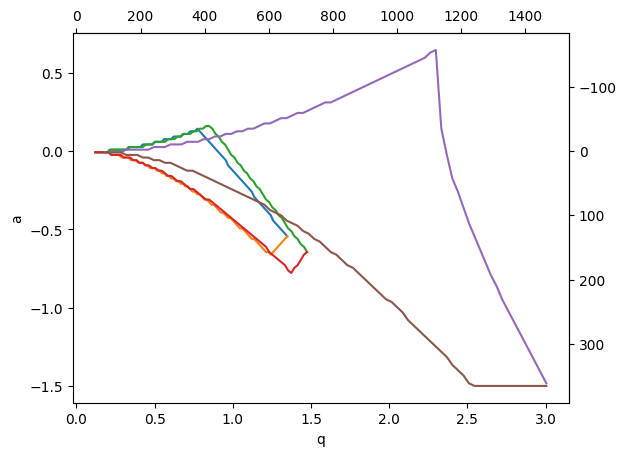

In [5]:
%matplotlib inline
kappaList = [0,0.2,1]
#q_array = np.linspace(0,3,100)
q_arrays = [np.linspace(0,1.5,100),np.linspace(0,2,100),np.linspace(0,3.5,100)]
topAs = []
bottomAs = []
topQs = []
bottomQs = []
a_array = np.linspace(-1.5,1,150)
fig,ax = plt.subplots()
for kappa,q_array in zip(kappaList,q_arrays):
    print(kappa)
    [topA,topQ,bottomA,bottomQ] = makeStabilityDiagram(a_array,q_array,kappa)
    topAs.append(topA)
    bottomAs.append(bottomA)
    topQs.append(topQ)
    bottomQs.append(bottomQ)
    ax.plot(topQ,topA)
    ax.plot(bottomQ,bottomA)




ax2x = ax.secondary_xaxis('top',functions = (qz_to_RFp,RF_to_qzp))
ax2y = ax.secondary_yaxis('right',functions = (az_to_DCp,DC_to_azp))
ax.set_xlabel('q')
ax.set_ylabel('a')

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\au581149\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "c:\Users\au581149\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\backends\_backend_tk.py", line 552, in destroy
    Gcf.destroy(self)
  File "c:\Users\au581149\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\_pylab_helpers.py", line 66, in destroy
    manager.destroy()
  File "c:\Users\au581149\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\backends\_backend_tk.py", line 569, in destroy
    self._window_dpi.trace_remove('write', self._window_dpi_cbname)
  File "c:\Users\au581149\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 477, in trace_remove
    self._tk.deletecommand(cbname)
_tkinter.TclError: can't delete Tcl command


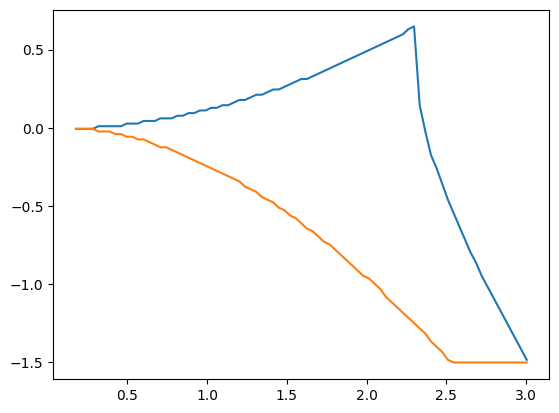

In [16]:
plt.plot(topQ,topA)
plt.plot(bottomQ,bottomA)

In [17]:
%matplotlib tk
linestyles = ['solid','dotted','dashed','dashdot']
fig, ax = plt.subplots()
for topA,bottomA,topQ,bottomQ,kappa,linestyle in zip(topAs,bottomAs,topQs,bottomQs,kappaList,linestyles):
    ax.plot(topQ,topA, color = 'k', ls = linestyle, label = rf'$\kappa = {kappa}$')
    ax.plot(bottomQ,bottomA, color = 'k', ls = linestyle)
ax.legend()
ax.set_xlabel(r'$q_z$')
ax.set_ylabel(r'$a_z$')
ax2x = ax.secondary_xaxis('top',functions = (qz_to_RFp,RF_to_qzp))
ax2y = ax.secondary_yaxis('right',functions = (az_to_DCp,DC_to_azp))
ax2x.set_xlabel('RF Voltage / V')
ax2y.set_ylabel('DC Voltage / V')

Text(0, 0.5, 'DC Voltage / V')

In [18]:
linestyles = ['solid','dotted','dashed','dashdot']
fig, ax = plt.subplots()
for topA,bottomA,topQ,bottomQ,kappa,linestyle in zip(topAs[0:3],bottomAs[0:3],topQs[0:3],bottomQs[0:3],kappaList[0:3],linestyles[0:3]):
    ax.plot(topQ,topA, color = 'k', ls = linestyle, label = rf'$\kappa = {kappa}$')
    ax.plot(bottomQ,bottomA, color = 'k', ls = linestyle)
ax.legend()
ax.set_xlim(0,1.5)
ax.set_ylim(-0.8,0.3)
ax.set_xlabel(r'$q_z$')
ax.set_ylabel(r'$a_z$')
ax2x = ax.secondary_xaxis('top',functions = (qz_to_RFp,RF_to_qzp))
ax2y = ax.secondary_yaxis('right',functions = (az_to_DCp,DC_to_azp))
ax2x.set_xlabel('RF Voltage / V')
ax2y.set_ylabel('DC Voltage / V')

Text(0, 0.5, 'DC Voltage / V')

In [ ]:
fig,ax = plt.subplots()
q_array = np.linspace(0,1.5,100)
a_array = np.linspace(-0.8,0.4)
[topA,topQ,bottomA,bottomQ] = makeStabilityDiagramDEVELOP(a_array,q_array,0.01)



-0.01632653061224487 0.18181818181818182


: 

In [10]:
q_array = np.linspace(0.845,860,1000)
a_array = np.linspace(0.15,0.175,1000)

[topA,topQ,bottomA,bottomQ] = makeStabilityDiagram(a_array,q_array,0.2)
# [topA2,topQ2,bottomA2,bottomQ2] = makeStabilityDiagram(a_array,q_array,0.0)



KeyboardInterrupt: 

In [8]:
%matplotlib tk

fig,ax = plt.subplots()

plt.plot(topQ,topA,color = 'red')
plt.plot(np.array(topQ)*444/443,np.array(topA)*444/443, color = 'green')
plt.plot(np.array(topQ)*445/443,np.array(topA)*445/443, color = 'blue')


plt.plot(topQ2,topA2,color = 'red', ls = '--')
plt.plot(np.array(topQ2)*444/443,np.array(topA2)*444/443, color = 'green', ls = '--')
plt.plot(np.array(topQ2)*445/443,np.array(topA2)*445/443, color = 'blue', ls = '--')
# plt.xlim(0.77,0.85)
# plt.ylim(0.145,0.151)
ax2x = ax.secondary_xaxis('top',functions = (qz_to_RFp,RF_to_qzp))
ax2y = ax.secondary_yaxis('right',functions = (az_to_DCp,DC_to_azp))
ax2x.set_xlabel('RF Voltage / V')
ax2y.set_ylabel('DC Voltage / V')
ax.set_xlabel(r'$q_{z,443}$')
ax.set_ylabel(r'$a_{z,443}$')
ax.plot([],[],ls = '--',color = 'k', label = r'$\kappa = 0$')
ax.plot([],[],ls = '-',color = 'k', label = r'$\kappa = 0.01$')
ax.scatter([],[],color = 'r',label = 'm = 443')
ax.scatter([],[],color = 'g',label = 'm = 444')
ax.scatter([],[],color = 'b',label = 'm = 445')
ax.legend()

In [ ]:
print(az_to_DC(np.array([0.148557,0.1482253,0.147928]),443,300*2*np.pi*1e3,2.36*1e-4))
print(np.diff(az_to_DC(np.array([0.148557,0.1482253,0.147928]),443,300*2*np.pi*1e3,2.36*1e-4)))

[-35.78320353 -35.70330633 -35.63169512]
[0.0798972  0.07161121]


In [ ]:
print(qz_to_RF(np.array([0.78171,0.78379,0.78584]),443,300*2*np.pi*1e3,2.36*1e-4))
print(np.diff(qz_to_RF(np.array([0.78171,0.78379,0.78584]),443,300*2*np.pi*1e3,2.36*1e-4)))

[376.58391096 377.58593797 378.57351267]
[1.00202701 0.9875747 ]
